# reflection questions

#### week 9

question 1

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# settings
n_samples = 100
n_simulations = 2000
np.random.seed(42)

# fixed X
X = np.linspace(1, 10, n_samples)
X_const = sm.add_constant(X)

# storage for coefficients and OLS reported SEs
sim_coefs = []
ols_reported_ses = []

for _ in range(n_simulations):
    # 1. generate heteroskedastic errors
    # variance increases as X increases
    noise = np.random.normal(0, scale=X*2, size=n_samples)
    
    # 2. create Y (True Beta1 = 2.5)
    y = 5 + 2.5 * X + noise
    
    # 3. run OLS
    model = sm.OLS(y, X_const).fit()
    
    sim_coefs.append(model.params[1]) # store Beta1 estimate
    ols_reported_ses.append(model.bse[1]) # store OLS reported SE

# results
true_se_simulation = np.std(sim_coefs)
avg_ols_se = np.mean(ols_reported_ses)

print(f"--- Heteroskedasticity Results ---")
print(f"True SE (via Simulation of DGP): {true_se_simulation:.4f}")
print(f"Avg OLS Reported SE (Assumption Violation): {avg_ols_se:.4f}")
print(f"Discrepancy: OLS underestimated uncertainty by {((true_se_simulation - avg_ols_se)/true_se_simulation)*100:.1f}%")

--- Heteroskedasticity Results ---
True SE (via Simulation of DGP): 0.4936
Avg OLS Reported SE (Assumption Violation): 0.4609
Discrepancy: OLS underestimated uncertainty by 6.6%


question 2

In [3]:
# settings
n_samples = 100
n_simulations = 2000
rho = 0.9  # High positive correlation
np.random.seed(42)

X = np.linspace(0, 10, n_samples)
X_const = sm.add_constant(X)

sim_coefs_corr = []
ols_reported_ses_corr = []

for _ in range(n_simulations):
    # 1. generate Correlated Errors (AR1 Process)
    # epsilon_t = rho * epsilon_{t-1} + noise
    errors = np.zeros(n_samples)
    noise = np.random.normal(0, 1, n_samples)
    for t in range(1, n_samples):
        errors[t] = rho * errors[t-1] + noise[t]
        
    # 2. create Y (True Beta1 = 2.5)
    y = 5 + 2.5 * X + errors
    
    # 3. run OLS
    model = sm.OLS(y, X_const).fit()
    
    sim_coefs_corr.append(model.params[1])
    ols_reported_ses_corr.append(model.bse[1])

# results
true_se_corr_sim = np.std(sim_coefs_corr)
avg_ols_corr_se = np.mean(ols_reported_ses_corr)

print(f"--- Correlated Errors Results ---")
print(f"True SE (via Simulation of DGP): {true_se_corr_sim:.4f}")
print(f"Avg OLS Reported SE (Assumption Violation): {avg_ols_corr_se:.4f}")
print(f"Discrepancy: OLS underestimated uncertainty by {((true_se_corr_sim - avg_ols_corr_se)/true_se_corr_sim)*100:.1f}%")

--- Correlated Errors Results ---
True SE (via Simulation of DGP): 0.2696
Avg OLS Reported SE (Assumption Violation): 0.0640
Discrepancy: OLS underestimated uncertainty by 76.3%


question 3

In [4]:
# 1. generate ONE dataset with the high correlation from above
np.random.seed(42)
errors = np.zeros(n_samples)
noise = np.random.normal(0, 1, n_samples)
for t in range(1, n_samples):
    errors[t] = 0.9 * errors[t-1] + noise[t]

y_sample = 5 + 2.5 * X + errors
data = pd.DataFrame({'y': y_sample, 'X': X})

# 2. naive bootstrap
n_bootstraps = 2000
boot_coefs = []

for _ in range(n_bootstraps):
    # resample with replacement (destroys time order)
    sample = data.sample(n=n_samples, replace=True)
    
    model_boot = sm.OLS(sample['y'], sm.add_constant(sample['X'])).fit()
    boot_coefs.append(model_boot.params['X'])

boot_se = np.std(boot_coefs)

print(f"--- Bootstrap Comparison ---")
print(f"True SE (from DGP Simulation in Part 2): {true_se_corr_sim:.4f}")
print(f"Naive Bootstrap SE: {boot_se:.4f}")
print(f"Standard OLS SE (on this sample): {sm.OLS(y_sample, X_const).fit().bse[1]:.4f}")

--- Bootstrap Comparison ---
True SE (from DGP Simulation in Part 2): 0.2696
Naive Bootstrap SE: 0.0722
Standard OLS SE (on this sample): 0.0661


#### week 11

question 1

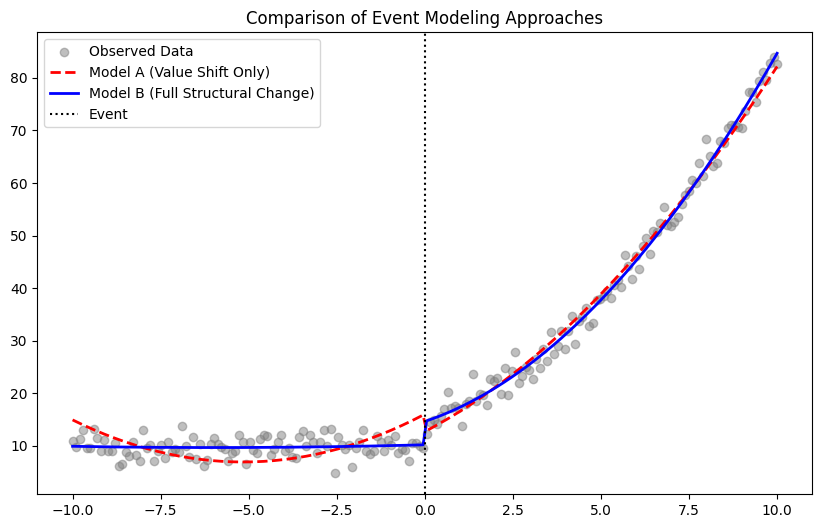

--- Model A (Value Change Only) ---
R-squared: 0.9853
Event Coef (D): -3.3251 (True Jump was 5.0)
AIC: 964.3

--- Model B (Value + Slope + Curve Change) ---
R-squared: 0.9928
Event Coef (D): 4.4408 (True Jump was 5.0)
Slope Change (D_t): 2.0678 (True was 2.0)
Curve Change (D_t_sq): 0.4613 (True was 0.5)
AIC: 824.8


In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

np.random.seed(42)
n = 200
t = np.linspace(-10, 10, n)

# event occurs at t=0
D = (t > 0).astype(int) # Dummy variable for post-event

# 2. true process
# Pre-event: flat line
# Post-event: jump by 5, slope increases by 2, curvature increases by 0.5
noise = np.random.normal(0, 2, n)

# use t*D and t^2*D to activate slope/curve changes only AFTER event
true_y = 10 + (5 * D) + (2 * t * D) + (0.5 * t**2 * D) + noise

df = pd.DataFrame({'t': t, 'y': true_y, 'D': D})
df['t_sq'] = df['t']**2

# interaction terms
# interact D with t and t^2 for slope and curve changes
df['D_t'] = df['D'] * df['t']
df['D_t_sq'] = df['D'] * df['t_sq']

# 3. build models
X = sm.add_constant(df[['t', 't_sq', 'D', 'D_t', 'D_t_sq']])

# Model A: checks only for value change (D), assuming slope/curve are constant across the whole period
# tries to fit a single parabola to the whole dataset
model_a = sm.OLS(df['y'], X[['const', 't', 't_sq', 'D']]).fit()

# Model B: checks for value (D), derivative (D_t), and 2nd derivative (D_t_sq) changes
model_b = sm.OLS(df['y'], X).fit()

# 4. visualization
plt.figure(figsize=(10, 6))
plt.scatter(t, true_y, alpha=0.5, label='Observed Data', color='gray')
plt.plot(t, model_a.predict(X[['const', 't', 't_sq', 'D']]), color='red', linestyle='--', linewidth=2, label='Model A (Value Shift Only)')
plt.plot(t, model_b.predict(X), color='blue', linewidth=2, label='Model B (Full Structural Change)')
plt.axvline(0, color='black', linestyle=':', label='Event')
plt.legend()
plt.title("Comparison of Event Modeling Approaches")
plt.show()

print("--- Model A (Value Change Only) ---")
print(f"R-squared: {model_a.rsquared:.4f}")
print(f"Event Coef (D): {model_a.params['D']:.4f} (True Jump was 5.0)")
print(f"AIC: {model_a.aic:.1f}\n")

print("--- Model B (Value + Slope + Curve Change) ---")
print(f"R-squared: {model_b.rsquared:.4f}")
print(f"Event Coef (D): {model_b.params['D']:.4f} (True Jump was 5.0)")
print(f"Slope Change (D_t): {model_b.params['D_t']:.4f} (True was 2.0)")
print(f"Curve Change (D_t_sq): {model_b.params['D_t_sq']:.4f} (True was 0.5)")
print(f"AIC: {model_b.aic:.1f}")

question 2

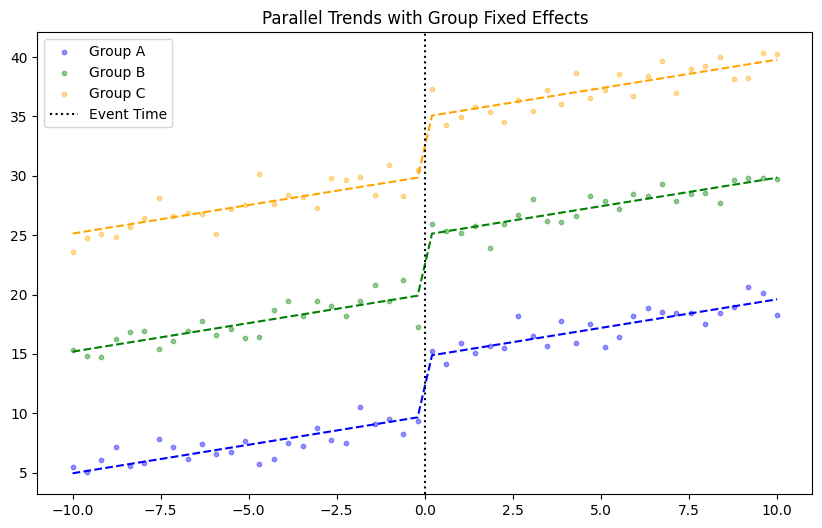

                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.7573      0.204     47.829      0.000       9.354      10.160
C(Group)[T.Group B]    10.2433      0.189     54.253      0.000       9.870      10.616
C(Group)[T.Group C]    20.1862      0.189    106.916      0.000      19.813      20.559
Time                    0.4807      0.026     18.356      0.000       0.429       0.532
PostEvent               5.0345      0.309     16.319      0.000       4.425       5.644

--- Interpretation ---
Estimated Event Impact (PostEvent): 5.0345 (True = 5.0)
Estimated Common Trend (Time):      0.4807 (True = 0.5)


In [7]:
import statsmodels.formula.api as smf

np.random.seed(42)
n_time_points = 50
time = np.linspace(-10, 10, n_time_points)

# define parameters
trend_slope = 0.5
event_impact = 5.0
group_baselines = {'Group A': 10, 'Group B': 20, 'Group C': 30}

data_rows = []

for group_name, baseline in group_baselines.items():
    # create dummy for post-event (1 if time > 0, else 0)
    post_event = (time > 0).astype(int)
    
    # generate Y: Baseline + Time Trend + Event Jump + Noise
    noise = np.random.normal(0, 1, n_time_points)
    y = baseline + (trend_slope * time) + (event_impact * post_event) + noise
    
    for t, y_val, post in zip(time, y, post_event):
        data_rows.append({
            'Time': t,
            'Y': y_val,
            'Group': group_name,
            'PostEvent': post
        })

df = pd.DataFrame(data_rows)

# 2. Fixed Effects Model
# Y ~ Time + PostEvent + C(Group)
model = smf.ols("Y ~ Time + PostEvent + C(Group)", data=df).fit()

# 3. Visualization
plt.figure(figsize=(10, 6))
colors = {'Group A': 'blue', 'Group B': 'green', 'Group C': 'orange'}

for grp in group_baselines.keys():
    subset = df[df['Group'] == grp]
    plt.scatter(subset['Time'], subset['Y'], alpha=0.4, label=grp, color=colors[grp], s=10)
    
    # Plot the fitted line for this group
    # predict using the model to show it fits the specific group levels correctly
    pred = model.predict(subset)
    plt.plot(subset['Time'], pred, color=colors[grp], linestyle='--')

plt.axvline(0, color='black', linestyle=':', label='Event Time')
plt.title("Parallel Trends with Group Fixed Effects")
plt.legend()
plt.show()

# 4. Results
print(model.summary().tables[1])

print(f"\n--- Interpretation ---")
print(f"Estimated Event Impact (PostEvent): {model.params['PostEvent']:.4f} (True = 5.0)")
print(f"Estimated Common Trend (Time):      {model.params['Time']:.4f} (True = 0.5)")

### week 12

question1

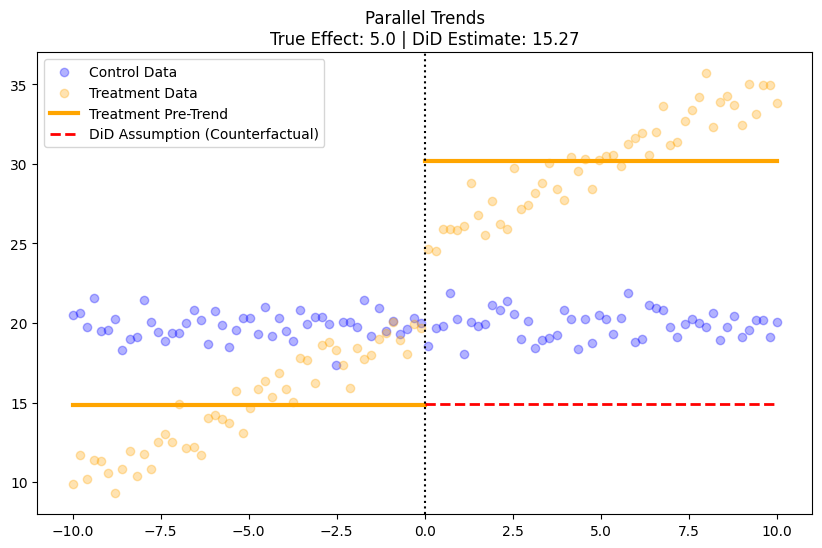

True Causal Effect: 5.0
DiD Estimated Effect: 15.2729
Bias: 10.2729


In [11]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 1. setup data
np.random.seed(42)
n_points = 100
time = np.linspace(-10, 10, n_points)

# Control: flat line (slope = 0)
# Treatment: naturally rising (slope = 1) even before treatment
control_slope = 0
treat_slope = 1.0 
true_effect = 5.0

df_list = []

for t in time:
    post = 1 if t > 0 else 0
    
    # Control Group Data
    # y = 20
    y_control = 20 + (control_slope * t) + np.random.normal(0, 1)
    df_list.append({'Time': t, 'Y': y_control, 'Group': 'Control', 'Treat': 0, 'Post': post})
    
    # Treatment Group Data
    # y = 20 + (1.0 * t) + (5.0 if post)
    # Note: The (1.0 * t) exists in BOTH pre and post periods (this is the violation!!)
    y_treat = 20 + (treat_slope * t) + (true_effect * post) + np.random.normal(0, 1)
    df_list.append({'Time': t, 'Y': y_treat, 'Group': 'Treatment', 'Treat': 1, 'Post': post})

df = pd.DataFrame(df_list)

# 2. Run DiD Model
# Y ~ Treat + Post + Treat*Post
# coefficient on 'Treat:Post' is the DiD estimate
model = smf.ols("Y ~ Treat * Post", data=df).fit()
did_estimate = model.params['Treat:Post']

# 3. visualization
plt.figure(figsize=(10, 6))

for grp, color in [('Control', 'blue'), ('Treatment', 'orange')]:
    subset = df[df['Group'] == grp]
    plt.scatter(subset['Time'], subset['Y'], color=color, alpha=0.3, label=f'{grp} Data')

pre_treat_mean = df[(df['Group']=='Treatment') & (df['Post']==0)]['Y'].mean()
post_treat_mean = df[(df['Group']=='Treatment') & (df['Post']==1)]['Y'].mean()
pre_control_mean = df[(df['Group']=='Control') & (df['Post']==0)]['Y'].mean()
post_control_mean = df[(df['Group']=='Control') & (df['Post']==1)]['Y'].mean()

expected_growth_control = post_control_mean - pre_control_mean
counterfactual_y = pre_treat_mean + expected_growth_control

plt.plot([-10, 0], [pre_treat_mean, pre_treat_mean], color='orange', linestyle='-', linewidth=3, label='Treatment Pre-Trend')
plt.plot([0, 10], [post_treat_mean, post_treat_mean], color='orange', linestyle='-', linewidth=3)
plt.plot([0, 10], [counterfactual_y, counterfactual_y], color='red', linestyle='--', linewidth=2, label='DiD Assumption (Counterfactual)')
plt.title(f"Parallel Trends\nTrue Effect: {true_effect} | DiD Estimate: {did_estimate:.2f}")
plt.legend()
plt.axvline(0, color='black', linestyle=':')
plt.show()

# 4. Results
print(f"True Causal Effect: {true_effect}")
print(f"DiD Estimated Effect: {did_estimate:.4f}")
print(f"Bias: {did_estimate - true_effect:.4f}")